## Bring in libraries and dataframes and set indexes

In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ETFunctions
%matplotlib inline
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.api as sm
import matplotlib.dates as mdates
import GraphHelpers as GH

In [2]:
WaterDelta = pd.read_pickle('.\DataFrames\ProfileWaterDelta.pkl')

In [3]:
Rainfall = pd.read_pickle('../BroadfieldsMet.pkl').Rainfall
Rainfall.name = 'Rainfall'

In [4]:
GPs = GH.SetGraphicsPatterns(WaterDelta.columns,
                    ['-','--'],
                    [0.15,0.45],
                    ['o','^'],
                    ['orange','green','purple'])

Start = WaterDelta.index.min()
End = WaterDelta.index.max()

Irrigation
['Excess', 'Normal']
Nitrogen
['125', '320', '80']
Treatments
MultiIndex(levels=[['Excess', 'Normal'], ['125', '320', '80']],
           labels=[[0, 0, 0, 1, 1, 1], [0, 1, 2, 0, 1, 2]])
Styles
[('-', 'orange', 0.15, 'o'), ('-', 'green', 0.15, 'o'), ('-', 'purple', 0.15, 'o'), ('--', 'orange', 0.45, '^'), ('--', 'green', 0.45, '^'), ('--', 'purple', 0.45, '^')]
StyleFrame
           Lin     Col   Alp Mar     MFC
Excess 125   -  orange  0.15   o  orange
       320   -   green  0.15   o   green
       80    -  purple  0.15   o  purple
Normal 125  --  orange  0.45   ^   white
       320  --   green  0.45   ^   white
       80   --  purple  0.45   ^   white


## investigate how much upward flux we are getting at night

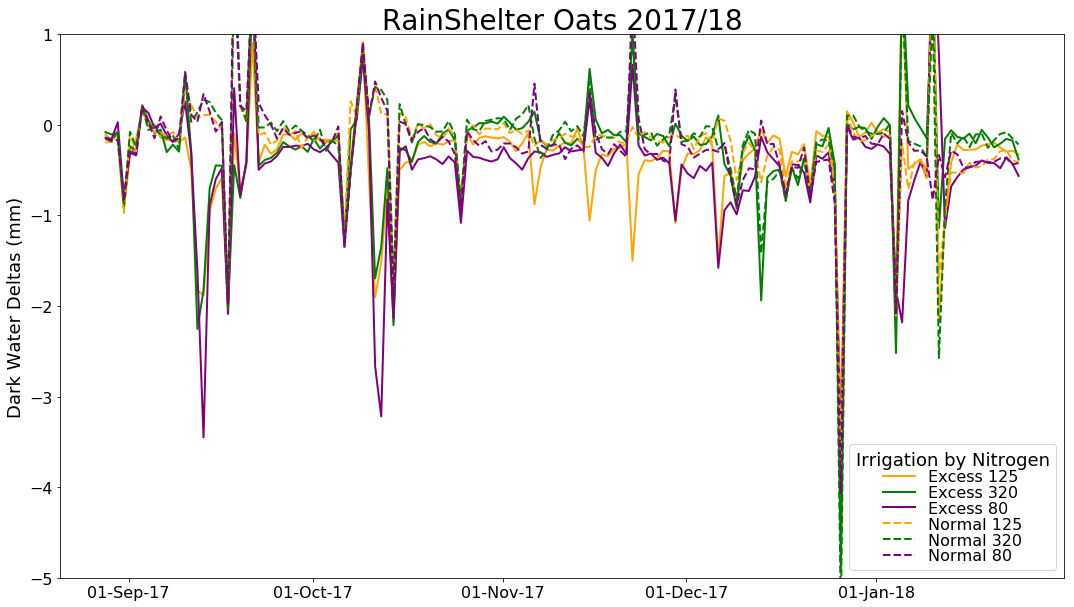

In [5]:
DarkWaterDeltas = WaterDelta.iloc[WaterDelta.index.indexer_between_time(datetime.time(23),datetime.time(4))]
DarkWaterDeltas = DarkWaterDeltas.resample('24H', base=5).sum()#Base of 5 means sampling from 6am to 6am
DarkRainfall = Rainfall.iloc[Rainfall.index.indexer_between_time(datetime.time(23),datetime.time(4))]
DarkRainfall = DarkRainfall.resample('24H', base=5).sum()
DarkWaterDeltas = DarkWaterDeltas.subtract(DarkRainfall.reindex(DarkWaterDeltas.index),axis=0)
MeanDarkWaterDeltas = DarkWaterDeltas.groupby(level=['Irrigation','Nitrogen'],axis=1).mean()

Graph = plt.figure(figsize=(18,10))
ax = Graph.add_subplot(1,1,1)
GH.AddIndexedPlot(MeanDarkWaterDeltas,ax,GPs,2)
GH.AddLegend(4,16,'Irrigation by Nitrogen')
GH.SetAxProps('RainShelter Oats 2017/18',28,'Dark Water Deltas (mm)',ylim=(-5,1))
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))

In [30]:
MeanDarkWaterDeltas.loc[MeanDarkWaterDeltas.Excess.mean(axis=1)<-0.9,:].index

DatetimeIndex(['2017-09-12 05:00:00', '2017-09-13 05:00:00',
               '2017-09-17 05:00:00', '2017-10-06 05:00:00',
               '2017-10-11 05:00:00', '2017-10-12 05:00:00',
               '2017-10-14 05:00:00', '2017-10-25 05:00:00',
               '2017-12-06 05:00:00', '2017-12-09 05:00:00',
               '2017-12-26 05:00:00', '2018-01-04 05:00:00'],
              dtype='datetime64[ns]', freq=None)

## No strong evidence of upward flux for this experiment

## Work out Irrigation timings and amounts.

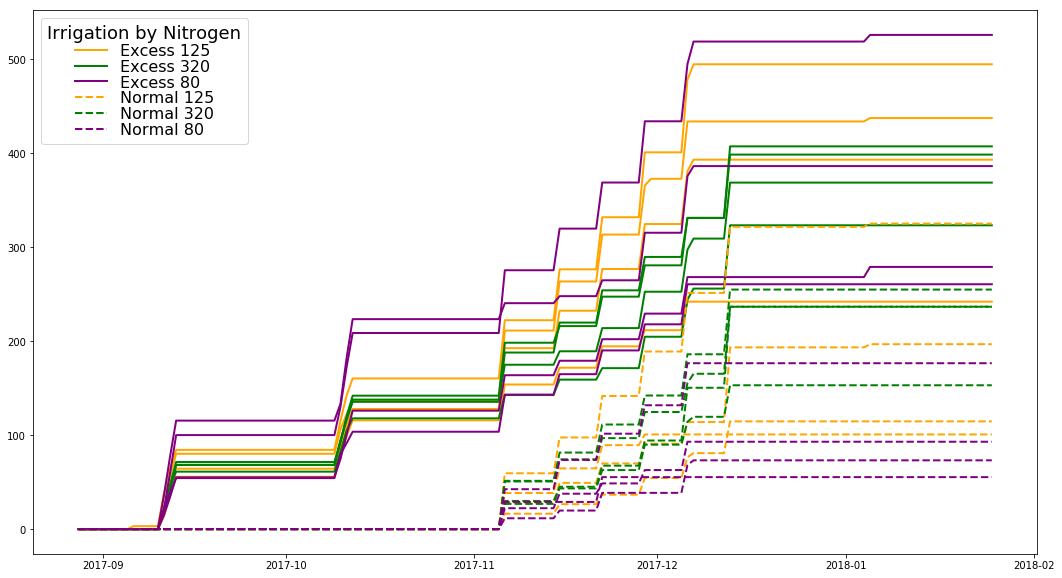

In [6]:
Irrigation = WaterDelta.where(WaterDelta > 3)
Irrigation = Irrigation.resample('D').sum()
Irrigation.fillna(0, inplace = True)
AccumIrrig = Irrigation.cumsum()
Graph = plt.figure(figsize=(18,10))
ax = Graph.add_subplot(1,1,1)
GH.AddIndexedPlot(AccumIrrig,ax,GPs,2)
GH.AddLegend(2,16,'Irrigation by Nitrogen')

In [7]:
DSIyesterday = 0

DaysSinceIrrigation = pd.DataFrame(index = Irrigation.index, columns = Irrigation.columns)
for col in range(DaysSinceIrrigation.columns.size):
    for x in range(Irrigation.index.size):
        if x == 0:
            DaysSinceIrrigation.iloc[x,col] = float(0)
        else: 
            if Irrigation.iloc[x,col] == 0:
                DaysSinceIrrigation.iloc[x,col] = float(DaysSinceIrrigation.iloc[x-1,col]+1)
            else:
                DaysSinceIrrigation.iloc[x,col] = float(0)

In [8]:
IrrDates = DaysSinceIrrigation.Normal.loc[:,'80'].mean(axis=1) == 0.0
IrrDatesD0 = IrrDates.loc[IrrDates].index.tolist()
IrrDates = DaysSinceIrrigation.Normal.loc[:,'125'].mean(axis=1) == 0.0
IrrDatesD50 = IrrDates.loc[IrrDates].index.tolist()
IrrDates = DaysSinceIrrigation.Normal.loc[:,'320'].mean(axis=1) == 0.0
IrrDatesD250 = IrrDates.loc[IrrDates].index.tolist()
IrrDates = DaysSinceIrrigation.Excess.loc[:,'80'].mean(axis=1) == 0.0
IrrDatesI0 = IrrDates.loc[IrrDates].index.tolist()
IrrDates = DaysSinceIrrigation.Excess.loc[:,'125'].mean(axis=1) == 0.0
IrrDatesI50 = IrrDates.loc[IrrDates].index.tolist()
IrrDates = DaysSinceIrrigation.Excess.loc[:,'320'].mean(axis=1) == 0.0
IrrDatesI250 = IrrDates.loc[IrrDates].index.tolist()


In [9]:
ExcludeDates = list(set(IrrDatesD0+IrrDatesD250+IrrDatesD50+IrrDatesI0+IrrDatesI250+IrrDatesI50))
ExcludeDates = pd.to_datetime(ExcludeDates)
ExcludeDates.sort_values()

DatetimeIndex(['2017-08-28', '2017-09-11', '2017-09-12', '2017-09-13',
               '2017-10-10', '2017-10-11', '2017-10-12', '2017-11-06',
               '2017-11-15', '2017-11-22', '2017-11-29', '2017-12-06',
               '2017-12-13'],
              dtype='datetime64[ns]', freq=None)

# Calculate hourly water use values

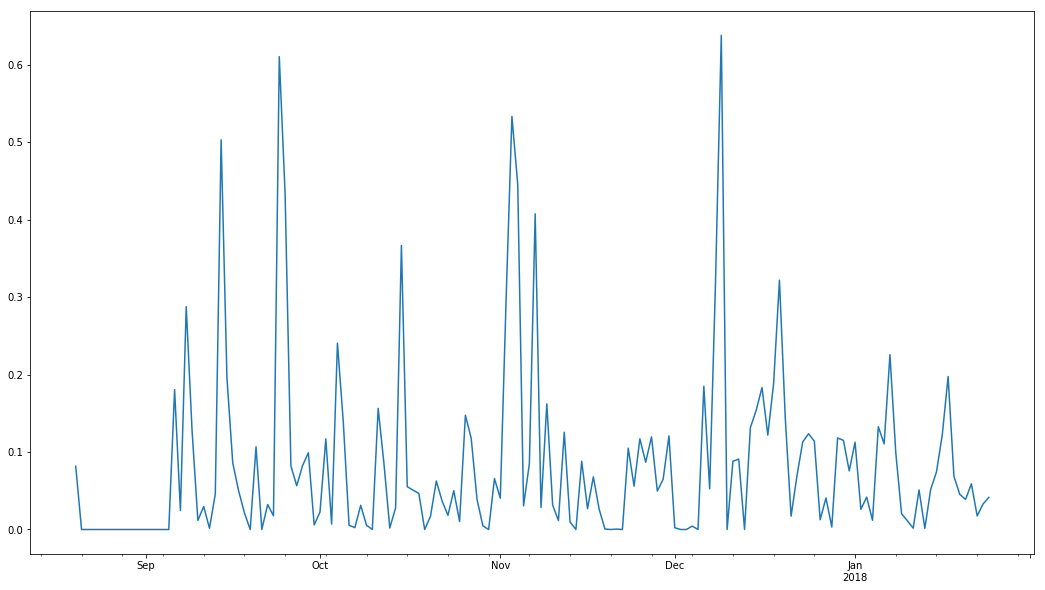

In [10]:
#Bring in night time PET data
NightTimePETAtmospheric = pd.read_pickle('.\DataFrames/NightTimePET.pkl')
NightTimePETAtmospheric.index = NightTimePETAtmospheric.index.normalize()
NightTimePETAtmospheric = NightTimePETAtmospheric.loc['2014-11-08':] #Drop of the first day because it only has a part nights numbers and no day associated wit it
NightTimePETAtmospheric.plot(figsize=(18,10))

## Calculate profile water content deltas for each 1 hour measurement period

(array([736663.95833333, 736664.20833333, 736664.45833333, 736664.70833333,
        736664.95833333, 736665.20833333, 736665.45833333, 736665.70833333,
        736665.95833333]), <a list of 9 Text xticklabel objects>)

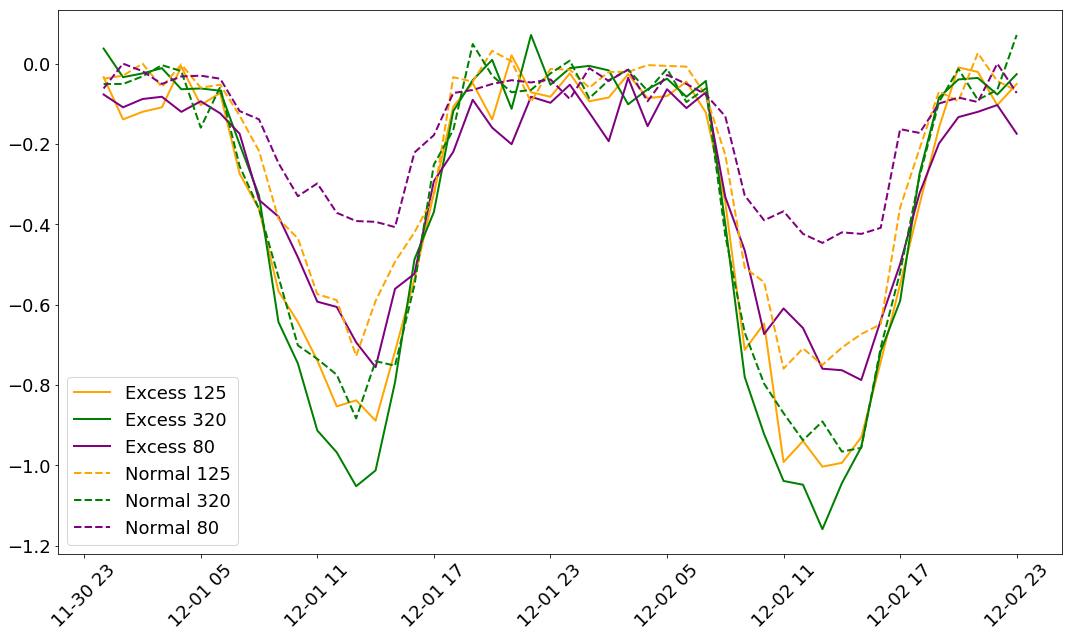

In [11]:
WaterDeltaHourly = WaterDelta.resample('h').sum()
MeanWaterDeltaHourly = WaterDeltaHourly.groupby(level=['Irrigation', 'Nitrogen'],axis=1).mean()
SEMWaterDeltaHourly = WaterDeltaHourly.groupby(level=['Irrigation', 'Nitrogen'],axis=1).std()/np.sqrt(4)
Graph = plt.figure(figsize=(18,10))
ax = Graph.add_subplot(1,1,1)
GH.AddIndexedPlot(MeanWaterDeltaHourly.loc['2017-12-1':'2017-12-2',:],ax,GPs,2)
plt.legend(fontsize=18)
plt.tick_params(labelsize=18)
plt.xticks(rotation=45)

In [12]:
UpwardFlux = DarkWaterDeltas.copy()
UpwardFlux.index = UpwardFlux.index.normalize()
for plot in  UpwardFlux:
    AdjustedFlux = UpwardFlux.loc[:,plot].values
    AdjustedFlux = np.add(AdjustedFlux,NightTimePETAtmospheric.reindex(UpwardFlux.index).values) # Add in the amount of evaporation that would have been replaced
    UpwardFlux.loc[:,plot] = AdjustedFlux
UpwardFlux = UpwardFlux.multiply(4)  # Multiply by 4 assuming upflux during the day were the same as at night
UpwardFlux.fillna(0, inplace = True)
UpwardFlux.where(UpwardFlux<3,0,inplace=True)
UpwardFlux.where(UpwardFlux>-2,0,inplace=True)
MeanUpwardFlux = UpwardFlux.groupby(level=['Irrigation','Nitrogen'],axis=1).mean()

(-3, 3)

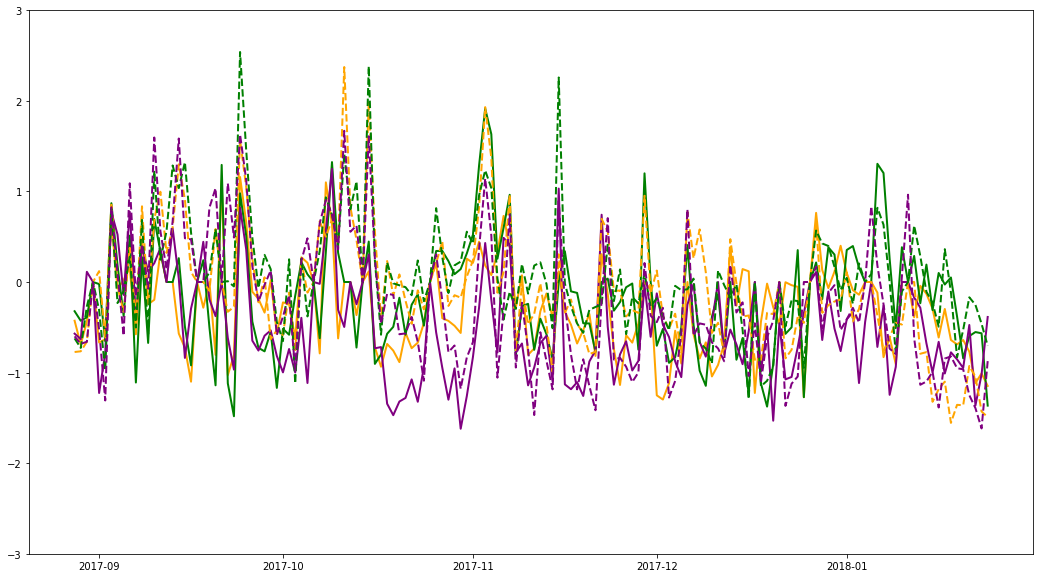

In [13]:
Graph = plt.figure(figsize=(18,10))
ax = Graph.add_subplot(1,1,1)
GH.AddIndexedPlot(MeanUpwardFlux,ax,GPs,2)
plt.ylim(-3,3)

(array([736663.95833333, 736664.20833333, 736664.45833333, 736664.70833333,
        736664.95833333, 736665.20833333, 736665.45833333, 736665.70833333,
        736665.95833333]), <a list of 9 Text xticklabel objects>)

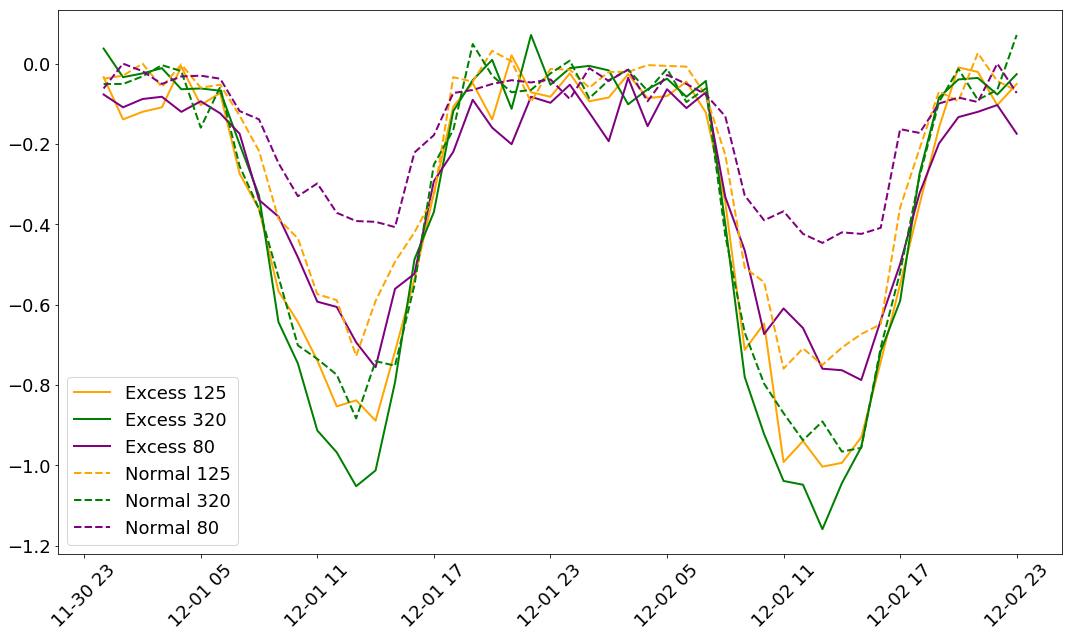

In [14]:
WaterDeltaHourly = WaterDelta.resample('h').sum()
MeanWaterDeltaHourly = WaterDeltaHourly.groupby(level=['Irrigation', 'Nitrogen'],axis=1).mean()
SEMWaterDeltaHourly = WaterDeltaHourly.groupby(level=['Irrigation', 'Nitrogen'],axis=1).std()/np.sqrt(4)
Graph = plt.figure(figsize=(18,10))
ax = Graph.add_subplot(1,1,1)
GH.AddIndexedPlot(MeanWaterDeltaHourly.loc['2017-12-1':'2017-12-2',:],ax,GPs,2)
plt.legend(fontsize=18)
plt.tick_params(labelsize=18)
plt.xticks(rotation=45)


(array([736573., 736603., 736634., 736664., 736695., 736726.]),
 <a list of 6 Text xticklabel objects>)

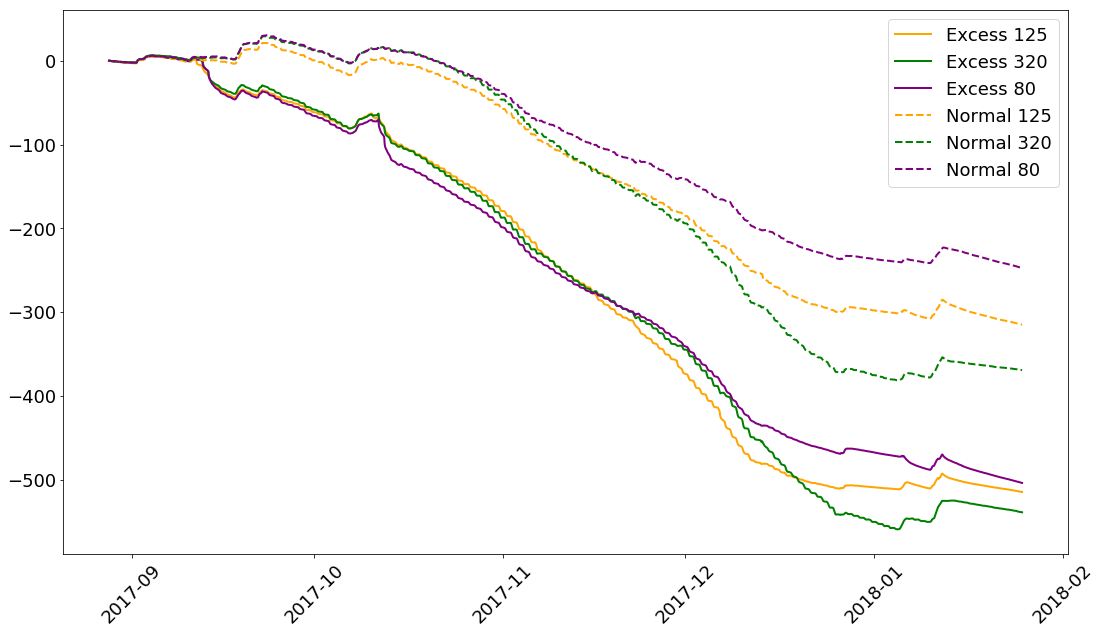

In [15]:
WaterUseHourly = WaterDeltaHourly.copy()
## Exclude large positive values which are where irrigation was applied
WaterUseHourly = WaterUseHourly.where(WaterUseHourly<1)
WaterUseHourly.fillna(method='ffill', inplace = True)
MeanWaterUseHourly = WaterUseHourly.groupby(level=['Irrigation', 'Nitrogen'],axis=1).mean()
Graph = plt.figure(figsize=(18,10))
ax = Graph.add_subplot(1,1,1)
GH.AddIndexedPlot(MeanWaterUseHourly.cumsum(),ax,GPs,2)
plt.legend(fontsize=18)
plt.tick_params(labelsize=18)
plt.xticks(rotation=45)

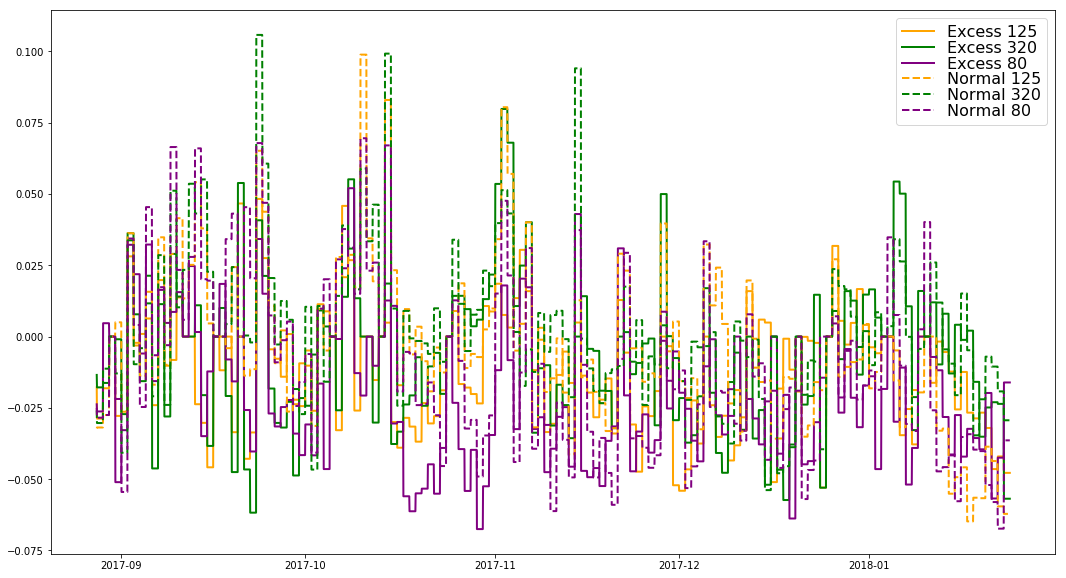

In [16]:
UpwardFluxHourlyArray = np.divide(UpwardFlux.values,24)
UpwardFluxHourly = pd.DataFrame(data = UpwardFluxHourlyArray,index=UpwardFlux.index,columns=UpwardFlux.columns)
UpwardFluxHourly = UpwardFluxHourly.resample('h').bfill()
MeanUpwardFluxHourly = UpwardFluxHourly.groupby(level=['Irrigation', 'Nitrogen'],axis=1).mean()
Graph = plt.figure(figsize=(18,10))
ax = Graph.add_subplot(1,1,1)
GH.AddIndexedPlot(MeanUpwardFluxHourly,ax,GPs,2)
GH.AddLegend(1,16,'')

(array([736578., 736592., 736606., 736620., 736634., 736648., 736662.,
        736676., 736690., 736704.]), <a list of 10 Text xticklabel objects>)

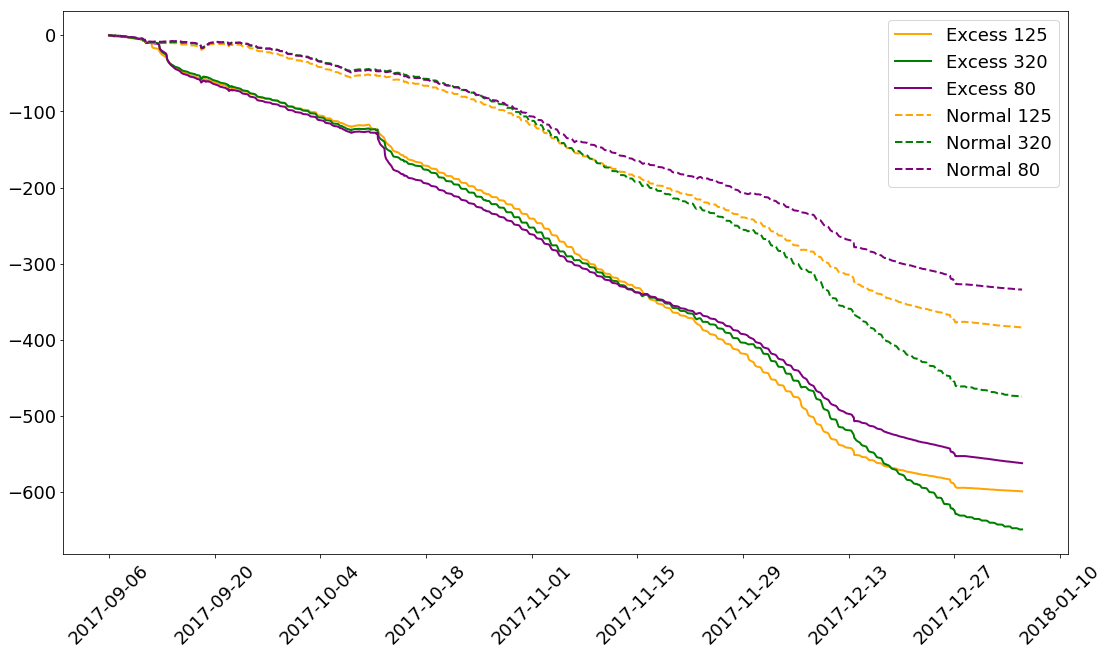

In [17]:
WaterUseHourly = WaterDeltaHourly#.subtract(UpwardFluxHourly) #Not subtracting upward flux becasue appeared small but lots of noise in it
RainfallHourly = Rainfall.resample('h').sum()
WaterUseHourly = WaterUseHourly.subtract(RainfallHourly.reindex(WaterUseHourly.index),axis=0)
WaterUseHourly = WaterUseHourly.where(WaterUseHourly<1)
WaterUseHourly.fillna(method='ffill', inplace = True)
MeanWaterUseHourly = WaterUseHourly.groupby(level=['Irrigation', 'Nitrogen'],axis=1).mean()
Graph = plt.figure(figsize=(18,10))
ax = Graph.add_subplot(1,1,1)
GH.AddIndexedPlot(MeanWaterUseHourly.loc['2017-09-06':'2018-01-04',:].cumsum(),ax,GPs,2)
plt.legend(fontsize=18)
plt.tick_params(labelsize=18)
plt.xticks(rotation=45)

## Output water use measurements for comparison to predictions

In [18]:
WaterUseHourly.to_pickle('.\DataFrames\HourlyWUmm.pkl')

## Calculate Daily Water Use

In [19]:
#Set up daily water use sums
WaterUseDaily = WaterUseHourly.resample('D').sum()
WaterUseDaily.index.name = 'Date'

#wipe the data on the days when irrigation occured 
WaterUseDaily.loc[IrrDatesD0,('Normal','80')] = np.nan
WaterUseDaily.loc[IrrDatesD50,('Normal','125')] = np.nan
WaterUseDaily.loc[IrrDatesD250,('Normal','320')] = np.nan
WaterUseDaily.loc[IrrDatesI0,('Excess','80')] = np.nan
WaterUseDaily.loc[IrrDatesI50,('Excess','125')] = np.nan
WaterUseDaily.loc[IrrDatesI250,('Excess','320')] = np.nan

(array([736573., 736603., 736634., 736664., 736695., 736726.]),
 <a list of 6 Text xticklabel objects>)

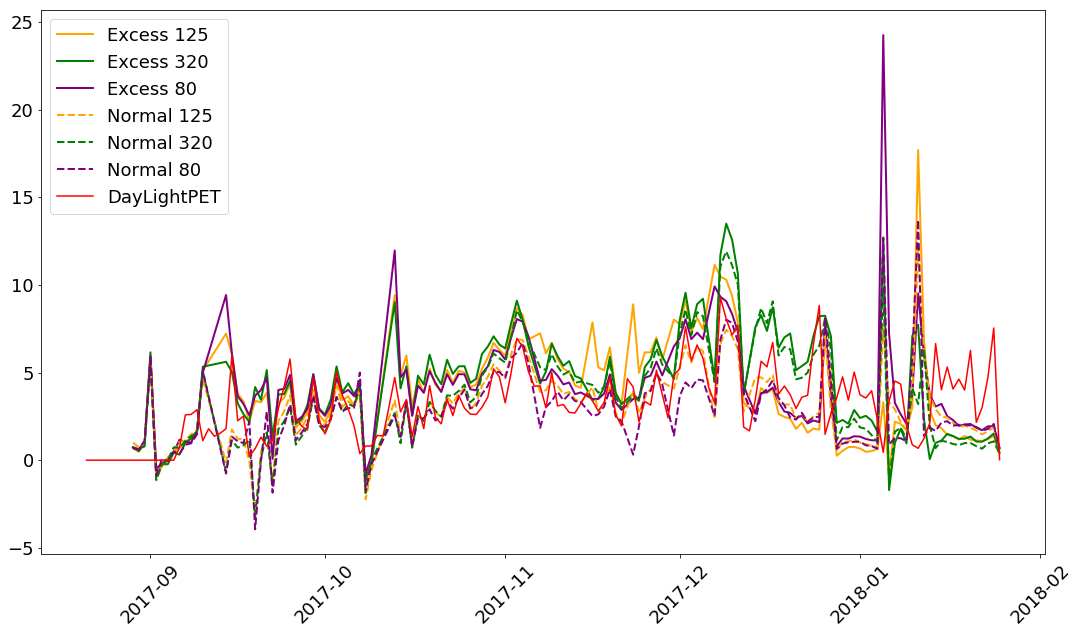

In [20]:
#calculate treatment means
WaterUseDailyMeans = WaterUseDaily.groupby(level=['Irrigation', 'Nitrogen'],axis=1).mean()
#Make water use positive
WaterUseDailyMeans = WaterUseDailyMeans.multiply(-1)

Graph = plt.figure(figsize=(18,10))
ax = Graph.add_subplot(1,1,1)
leaveIn = [x not in ExcludeDates for x in WaterUseDailyMeans.index]
GH.AddIndexedPlot(WaterUseDailyMeans.loc[leaveIn,:],ax,GPs,2)
DayTimePET = pd.read_pickle('.\DataFrames\DayTimePET.pkl')
DayTimePET.index = DayTimePET.index.normalize()
plt.plot(DayTimePET,'-r')
plt.legend(fontsize=18)
plt.tick_params(labelsize=18)
plt.xticks(rotation=45)



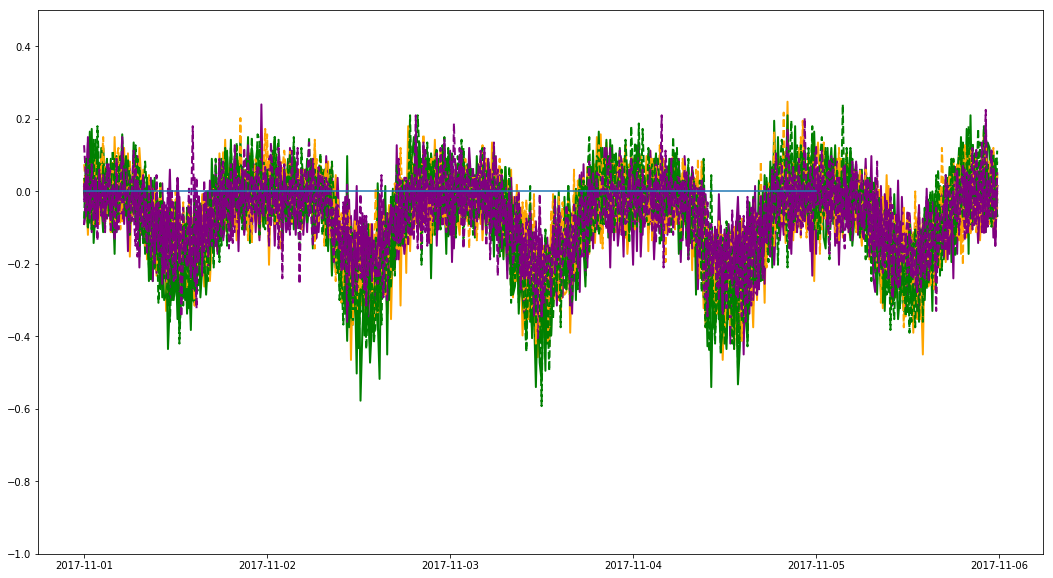

In [21]:
Graph = plt.figure(figsize=(18,10))
ax = Graph.add_subplot(1,1,1)
leaveIn = [x not in ExcludeDates for x in WaterUseDailyMeans.index]

GH.AddIndexedPlot(WaterDelta.loc['2017-11-01':'2017-11-5',:],ax,GPs,2)
plt.ylim(-1,.5)
plt.plot(pd.to_datetime(['2017-11-01','2017-11-5']),[0,0])

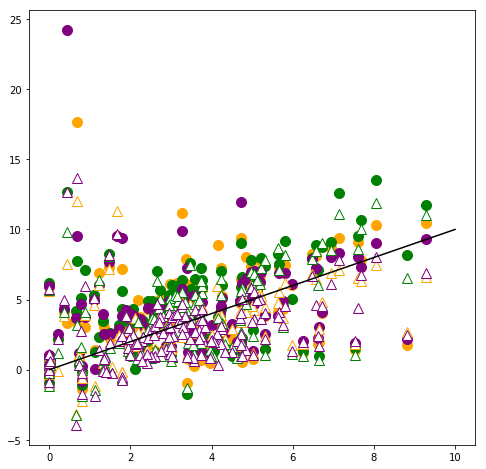

In [22]:
Graph = plt.figure(figsize=(8,8))
ax = Graph.add_subplot(1,1,1)
GH.AddIndexedXY(DayTimePET,WaterUseDailyMeans.reindex(DayTimePET.index.normalize()),ax,GPs,10)
plt.plot([0,10],[0,10],'-k')